This notebook includes the notes and the exercises of Week 4 of Crash course in Causality, Penn University

Colab Link: https://colab.research.google.com/drive/18q6jyD_8Q6W_UyLy2AVvnzQlXqc5Kwzp

References:
- Crash course in Causality, Penn University, Coursera

# Set Environment


In [158]:
#set R environment
cat(system('python3 -c "from google.colab import drive\ndrive.mount()"', intern=TRUE), sep='\n', wait=TRUE)

Warning message in system("python3 -c \"from google.colab import drive\ndrive.mount()\"", :
“running command 'python3 -c "from google.colab import drive
drive.mount()"' had status 1”



TRUE


In [159]:
install.packages("tableone")
install.packages("ipw")
install.packages("sandwich")
install.packages("survey")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [0]:
#load packages
library(tableone)
library(ipw)
library(sandwich) #for robust variance estimation
library(survey)
#library(cobalt)

# Load Data

In [161]:
#create logaritmic and exponential functions
expit <- function(x) {1/(1+exp(-x)) }
logit <- function(p) {log(p)-log(1-p)}
#read in data
load(url("http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/rhc.sav"))
#view data
rhc

,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,chfhx,⋯,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
,<fct>,<fct>,<fct>,<labelled>,<labelled>,<labelled>,<labelled>,<fct>,<labelled>,<labelled>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<labelled>,<labelled>,<fct>,<fct>,<labelled>
1,COPD,NA,Yes,11142,11151,NA,11382,No,0,0,⋯,No,No,No,No,No,0,NA,white,Under $11k,00005
2,MOSF w/Sepsis,NA,No,11799,11844,11844,11844,Yes,1,1,⋯,No,No,Yes,No,No,NA,1437,white,Under $11k,00007
3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143,NA,12400,No,0,0,⋯,No,No,No,No,No,NA,599,white,$25-$50k,00009
4,ARF,NA,No,11146,11183,11183,11182,Yes,0,0,⋯,No,No,No,No,No,NA,NA,white,$11-$25k,00010
5,MOSF w/Sepsis,NA,No,12035,12037,12037,12036,Yes,0,0,⋯,No,No,No,No,No,NA,64,white,Under $11k,00011
6,COPD,NA,No,12389,12396,NA,12590,No,0,1,⋯,No,No,No,No,No,0,242,white,Under $11k,00012
7,MOSF w/Malignancy,NA,Metastatic,12381,12423,NA,12616,No,0,0,⋯,No,No,No,No,No,NA,4465,white,$25-$50k,00013
8,ARF,Coma,No,11453,11487,11491,11490,Yes,0,0,⋯,No,No,Yes,No,No,NA,NA,white,$25-$50k,00014
9,MOSF w/Malignancy,NA,Yes,12426,12437,NA,12560,No,0,0,⋯,No,Yes,No,No,No,NA,5525,white,Under $11k,00016


In [0]:
#create a data set with just these variables, for simplicity
ARF<-as.numeric(rhc$cat1=='ARF')
CHF<-as.numeric(rhc$cat1=='CHF')
Cirr<-as.numeric(rhc$cat1=='Cirrhosis')
colcan<-as.numeric(rhc$cat1=='Colon Cancer')
Coma<-as.numeric(rhc$cat1=='Coma')
COPD<-as.numeric(rhc$cat1=='COPD')
lungcan<-as.numeric(rhc$cat1=='Lung Cancer')
MOSF<-as.numeric(rhc$cat1=='MOSF w/Malignancy')
sepsis<-as.numeric(rhc$cat1=='MOSF w/Sepsis')
female<-as.numeric(rhc$sex=='Female')
died<-as.integer(rhc$death=='Yes')
age<-rhc$age
treatment<-as.numeric(rhc$swang1=='RHC')
meanbp1<-rhc$meanbp1

#new dataset
mydata<-cbind(ARF,CHF,Cirr,colcan,Coma,lungcan,MOSF,sepsis,
              age,female,meanbp1,treatment,died)
mydata<-data.frame(mydata)

In [0]:
#covariates we will use (shorter list than you would use in practice)
xvars<-c("age","female","meanbp1","ARF","CHF","Cirr","colcan",
         "Coma","lungcan","MOSF","sepsis")

In [164]:
#look at a table 1
table1<- CreateTableOne(vars=xvars,strata="treatment", data=mydata, test=FALSE)
## include standardized mean difference (SMD)
print(table1,smd=TRUE)

                     Stratified by treatment
                      0             1             SMD   
  n                    3551          2184               
  age (mean (SD))     61.76 (17.29) 60.75 (15.63)  0.061
  female (mean (SD))   0.46 (0.50)   0.41 (0.49)   0.093
  meanbp1 (mean (SD)) 84.87 (38.87) 68.20 (34.24)  0.455
  ARF (mean (SD))      0.45 (0.50)   0.42 (0.49)   0.059
  CHF (mean (SD))      0.07 (0.25)   0.10 (0.29)   0.095
  Cirr (mean (SD))     0.05 (0.22)   0.02 (0.15)   0.145
  colcan (mean (SD))   0.00 (0.04)   0.00 (0.02)   0.038
  Coma (mean (SD))     0.10 (0.29)   0.04 (0.20)   0.207
  lungcan (mean (SD))  0.01 (0.10)   0.00 (0.05)   0.095
  MOSF (mean (SD))     0.07 (0.25)   0.07 (0.26)   0.018
  sepsis (mean (SD))   0.15 (0.36)   0.32 (0.47)   0.415


In [0]:
#propensity score model
psmodel <- glm(treatment ~ age + female + meanbp1+ARF+CHF+Cirr+colcan+
         Coma+lungcan+MOSF+sepsis,
               family  = binomial(link ="logit"))

## value of propensity score for each subject
ps <-predict(psmodel, type = "response")

In [166]:
#create weights
weight<-ifelse(treatment==1,1/(ps),1/(1-ps))

#apply weights to data
weighteddata<-svydesign(ids = ~ 1, data =mydata, weights = ~ weight)

#weighted table 1
weightedtable <-svyCreateTableOne(vars = xvars, strata = "treatment", 
                                 data = weighteddata, test = FALSE)
## Show table with SMD
print(weightedtable, smd = TRUE)

                     Stratified by treatment
                      0               1               SMD   
  n                   5732.49         5744.88               
  age (mean (SD))       61.36 (17.56)   61.43 (15.33)  0.004
  female (mean (SD))     0.45 (0.50)     0.45 (0.50)   0.001
  meanbp1 (mean (SD))   78.60 (37.58)   79.26 (40.31)  0.017
  ARF (mean (SD))        0.44 (0.50)     0.44 (0.50)   0.010
  CHF (mean (SD))        0.08 (0.27)     0.08 (0.27)   0.005
  Cirr (mean (SD))       0.04 (0.19)     0.04 (0.19)   0.001
  colcan (mean (SD))     0.00 (0.04)     0.00 (0.06)   0.042
  Coma (mean (SD))       0.08 (0.26)     0.07 (0.25)   0.023
  lungcan (mean (SD))    0.01 (0.08)     0.01 (0.09)   0.014
  MOSF (mean (SD))       0.07 (0.26)     0.07 (0.26)   0.004
  sepsis (mean (SD))     0.21 (0.41)     0.22 (0.41)   0.002


In [167]:
#to get a weighted mean for a single covariate directly:
mean(weight[treatment==1]*age[treatment==1])/(mean(weight[treatment==1]))

[1] 61.42933

In [168]:
#get causal risk difference
glm.obj<-glm(died~treatment,weights=weight,family=quasibinomial(link="identity"))
#summary(glm.obj)
betaiptw<-coef(glm.obj)
SE<-sqrt(diag(vcovHC(glm.obj, type="HC0")))

causalrd<-(betaiptw[2])
lcl<-(betaiptw[2]-1.96*SE[2])
ucl<-(betaiptw[2]+1.96*SE[2])
c(lcl,causalrd,ucl)

treatment  treatment  treatment 
0.02333223 0.05154951 0.07976679

In [0]:
#get causal relative risk. Weighted GLM
glm.obj<-glm(died~treatment,weights=weight,family=quasibinomial(link=log))
#summary(glm.obj)
betaiptw<-coef(glm.obj)
#to properly account for weighting, use asymptotic (sandwich) variance
SE<-sqrt(diag(vcovHC(glm.obj, type="HC0")))

In [170]:
#get point estimate and CI for relative risk (need to exponentiate)
causalrr<-exp(betaiptw[2])
lcl<-exp(betaiptw[2]-1.96*SE[2])
ucl<-exp(betaiptw[2]+1.96*SE[2])
c(lcl,causalrr,ucl)

treatment treatment treatment 
 1.036698  1.081764  1.128790

In [171]:
#truncate weights at 10
truncweight<-replace(weight,weight>10,10)
#get causal risk difference
glm.obj<-glm(died~treatment,weights=truncweight,family=quasibinomial(link="identity"))
#summary(glm.obj)
betaiptw<-coef(glm.obj)
SE<-sqrt(diag(vcovHC(glm.obj, type="HC0")))

causalrd<-(betaiptw[2])
lcl<-(betaiptw[2]-1.96*SE[2])
ucl<-(betaiptw[2]+1.96*SE[2])
c(lcl,causalrd,ucl)

treatment  treatment  treatment 
0.02768882 0.05493243 0.08217605

## alternative: use ipw package

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.046   1.405   1.721   2.001   2.280  21.606 

(Intercept)   treatment 
 0.63046375  0.05154951

,2.5 %,97.5 %
(Intercept),0.61401445,0.64691305
treatment,0.02333029,0.07976873


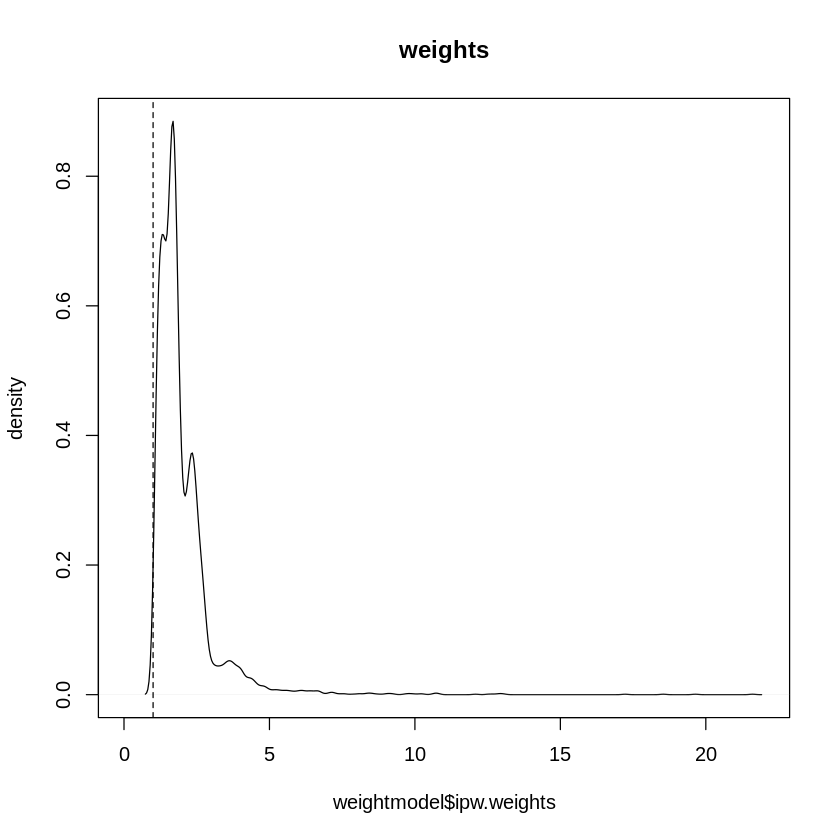

In [172]:
#first fit propensity score model to get weights
weightmodel<-ipwpoint(exposure= treatment, family = "binomial", link ="logit",
          denominator= ~ age + female + meanbp1+ARF+CHF+Cirr+colcan+
           Coma+lungcan+MOSF+sepsis, data=mydata)
#numeric summary of weights
summary(weightmodel$ipw.weights)
#plot of weights
ipwplot(weights = weightmodel$ipw.weights, logscale = FALSE,
         main = "weights", xlim = c(0, 22))
mydata$wt<-weightmodel$ipw.weights

#fit a marginal structural model (risk difference)
msm <- (svyglm(died ~ treatment, design = svydesign(~ 1, weights = ~wt,
                  data =mydata)))
coef(msm)
confint(msm)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.081   1.405   1.721   1.972   2.280   6.379 

(Intercept)   treatment 
 0.63045533  0.05494865

,2.5 %,97.5 %
(Intercept),0.61400659,0.64690406
treatment,0.02822931,0.08166799


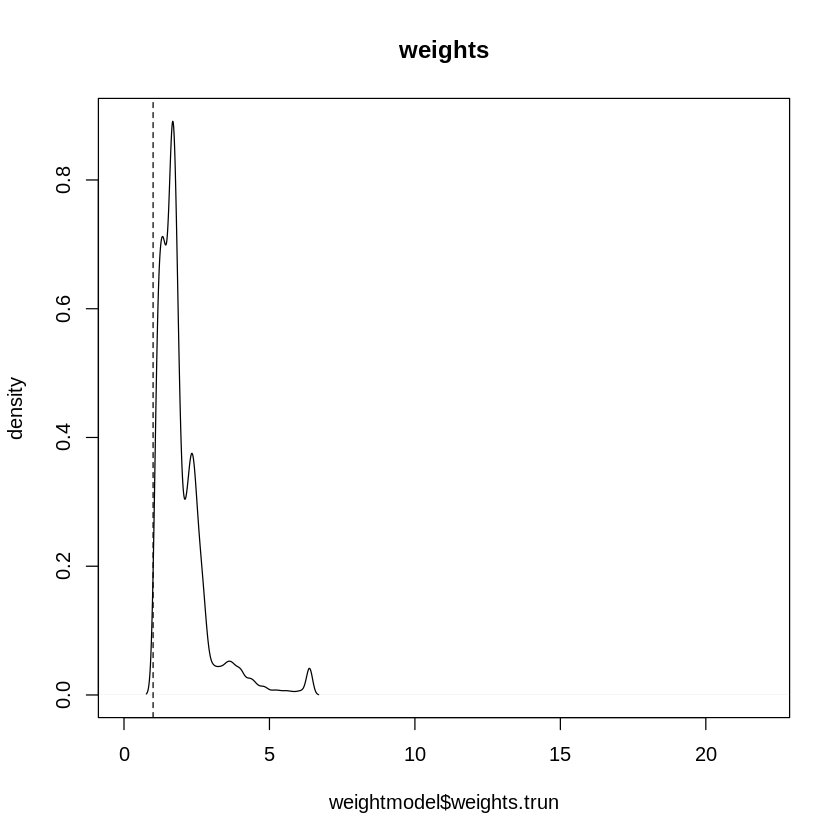

In [173]:
# fit propensity score model to get weights, but truncated
weightmodel<-ipwpoint(exposure= treatment, family = "binomial", link ="logit",
                      denominator= ~ age + female + meanbp1+ARF+CHF+Cirr+colcan+
                        Coma+lungcan+MOSF+sepsis, data=mydata,trunc=.01)

#numeric summary of weights
summary(weightmodel$weights.trun)
#plot of weights
ipwplot(weights = weightmodel$weights.trun, logscale = FALSE,
        main = "weights", xlim = c(0, 22))
mydata$wt<-weightmodel$weights.trun
#fit a marginal structural model (risk difference)
msm <- (svyglm(died ~ treatment, design = svydesign(~ 1, weights = ~wt,
                                                    data =mydata)))
coef(msm)
confint(msm)


# practice outside course

https://cran.rstudio.com/web/packages/cobalt/vignettes/cobalt_A4_love.plot.html

In [174]:
install.packages("cobalt")
install.packages("WeightIt")
install.packages("CBPS")
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [0]:
library(cobalt)
library(WeightIt)
library(CBPS)
library(ggplot2)

In [0]:
#get data
data("lalonde", package = "cobalt")

# find weight with weightit
w.out1 <- weightit(treat ~ age + educ + married + nodegree + race + re74 + re75,
                   data = lalonde, estimand = "ATE", method = "ps")
# set std as we are looking for SMD and so we do not need to print it everytime
set.cobalt.options(binary = "std")

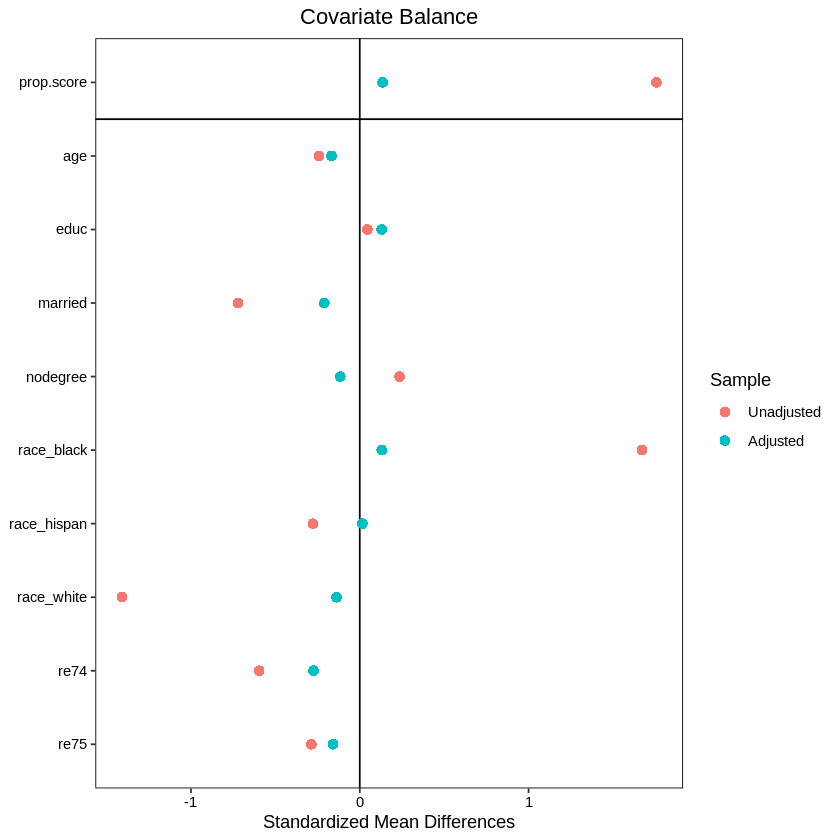

In [177]:
# simple love plot
love.plot(w.out1)

In [0]:
# set new names for clarity
new.names <- c(age = "Age (Years)",
               educ = "Education (Years)",
               married = "Married (Y/N)",
               nodegree = "Degree Earned (Y/N)",
               race_white = "Race: White",
               race_black = "Race: Black",
               race_hispan = "Race: Hispanic",
               re74 = "Earnings in 1974 ($)",
               re75 = "Earnings in 1975 ($)"
)

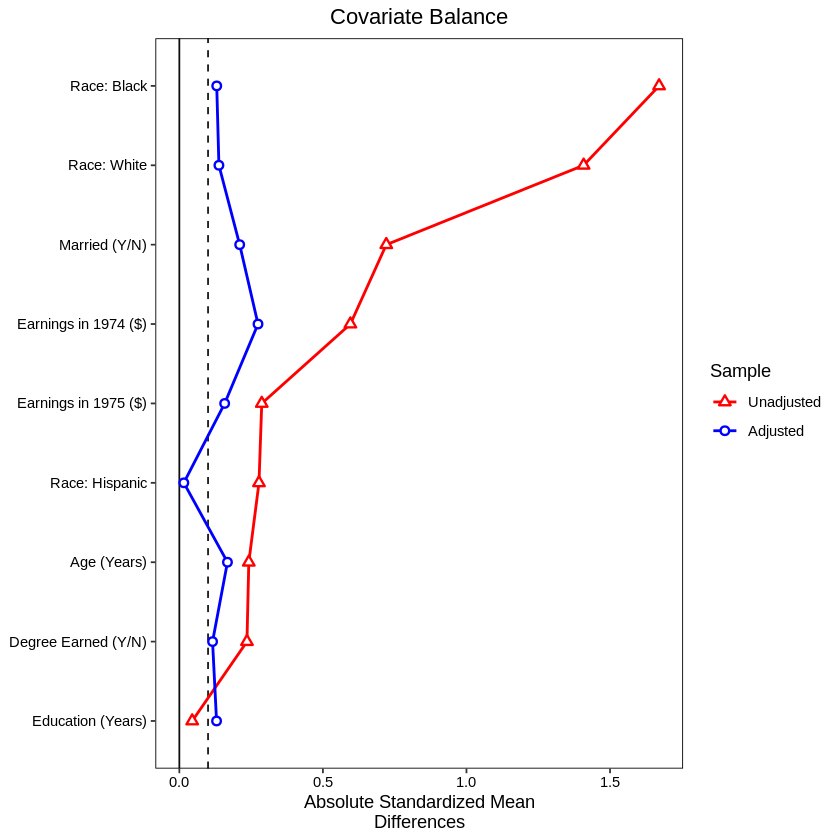

In [179]:
love.plot(w.out1, 
          drop.distance = TRUE, # remove prop score from plot
          var.order = "unadjusted", # order by highest unadjusted results
          abs = TRUE, # show absolute difference
          line = TRUE, 
          thresholds = c(m = .1), # set acceptable threshold
          var.names = new.names,
          colors = c("red", "blue"),
          shapes = c("triangle filled", "circle filled"))

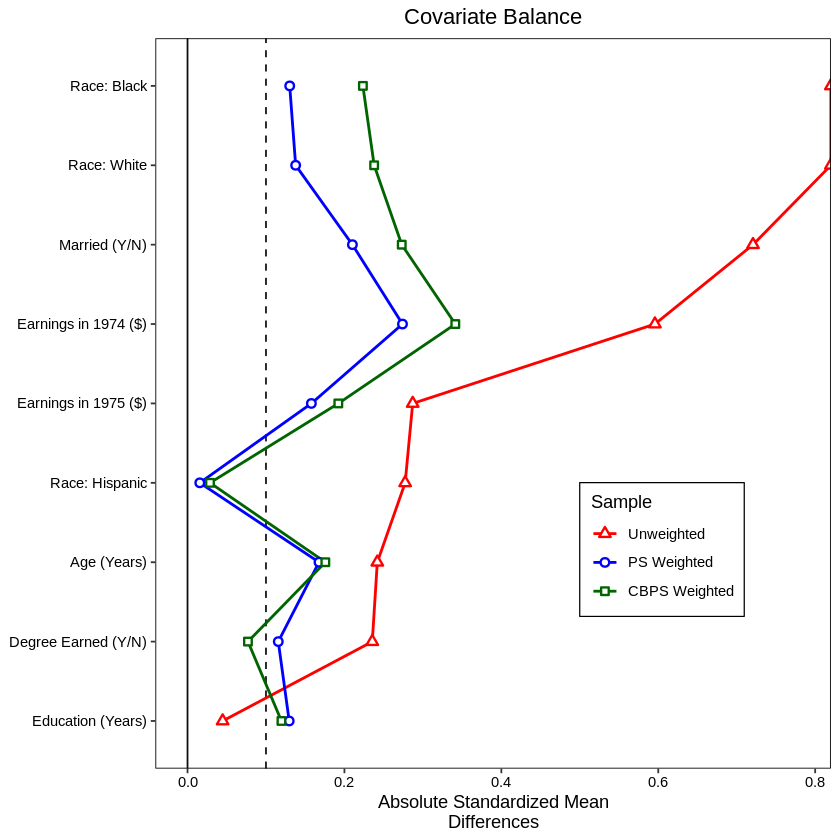

In [180]:
w.out2 <- weightit(treat ~ age + educ + married + nodegree + race + re74 + re75,
                   data = lalonde, estimand = "ATE", method = "cbps")

love.plot(treat ~ age + educ + married + nodegree + race + re74 + re75,
          data = lalonde, estimand = "ATE",
          weights = list(w1 = get.w(w.out1),
                         w2 = get.w(w.out2)),
          var.order = "unadjusted",
          abs = TRUE,
          line = TRUE, 
          thresholds = c(m = .1),
          var.names = new.names,
          colors = c("red", "blue", "darkgreen"),
          shapes = c("triangle filled", "circle filled", "square filled"),
          sample.names = c("Unweighted", "PS Weighted", "CBPS Weighted"),
          limits = c(0, .82)) +
  theme(legend.position = c(.75, .3),
        legend.box.background = element_rect(), 
        legend.box.margin = margin(1, 1, 1, 1))

# Week 4 final quiz

For this assignment we will use data from Lalonde (1986), that aimed to evaluate the impact of National Supported Work (NSW) Demonstration, which is a labor training program, on post-intervention income levels. Interest is in estimating the causal effect of this training program on income.

Fit a propensity score model. Use a logistic regression model, where the outcome is treatment. Include the 8 confounding variables in the model as predictors, with no interaction terms or non-linear terms (such as squared terms). Obtain the propensity score for each subject. Next, obtain the inverse probability of treatment weights for each subject.

In [181]:
# load libaries not previously installed
install.packages("Matching")
install.packages("MatchIt")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [0]:
library(Matching)
library(MatchIt)

## data info

The data have n=614 subjects and 10 variables

* age age in years.

* educ years of schooling.

* black indicator variable for blacks.

* hispan indicator variable for Hispanics.

* married indicator variable for marital status.

* nodegree indicator variable for high school diploma.

* re74 real earnings in 1974.

* re75 real earnings in 1975.

* re78 real earnings in 1978.

* treat an indicator variable for treatment status.

The outcome is re78 – post-intervention income.

The treatment is treat – which is equal to 1 if the subject received the labor training and equal to 0 otherwise.

The potential confounding variables are: age, educ, black, hispan, married, nodegree, re74, re75.

In [183]:
# load data
data(lalonde, package = 'MatchIt')
colnames(lalonde)

[1] "treat"    "age"      "educ"     "black"    "hispan"   "married" 
 [7] "nodegree" "re74"     "re75"     "re78"

# Question 1
What are the minimum and maximum weights? !!! reponse incorrect



In [184]:
xvars = c('age', 'educ', 'black', 'hispan', 'married', 'nodegree',
          're74', 're75')

# propensity score model
psmodel <- glm(treat ~ age + educ + black + hispan + married 
                + nodegree + re75 + re74, data = lalonde, family = "binomial")
# fit propensity scores
ps <- predict(psmodel, type='response') 
# create weights
weight<-ifelse(lalonde$treat==1,1/(ps),1/(1-ps))
# find min and max
print(min(weight))
print(max(weight))

[1] 1.009163
[1] 40.07729


# Question 2

Find the standardized differences for each confounder on the weighted (pseudo) population. What is the standardized difference for nodegree?

In [185]:
# fit propensity score model to get weights
weightmodel <- ipwpoint(exposure = treat,
                        family='binomial',
                        link='logit',
                        denominator=~age+educ+black+hispan+married+
                        nodegree+re74+re75,
                        data=lalonde)

#apply weights to data
weighted_data <- svydesign(ids = ~1, data=lalonde,
                           weights = ~ weightmodel$ipw.weights)


# weighted table 1
weightedtable1 <- svyCreateTableOne(vars=xvars, strata='treat',
                                   data=weighted_data, test = FALSE)
# show table with SMD
print(weightedtable, smd=TRUE)

                     Stratified by treatment
                      0               1               SMD   
  n                   5732.49         5744.88               
  age (mean (SD))       61.36 (17.56)   61.43 (15.33)  0.004
  female (mean (SD))     0.45 (0.50)     0.45 (0.50)   0.001
  meanbp1 (mean (SD))   78.60 (37.58)   79.26 (40.31)  0.017
  ARF (mean (SD))        0.44 (0.50)     0.44 (0.50)   0.010
  CHF (mean (SD))        0.08 (0.27)     0.08 (0.27)   0.005
  Cirr (mean (SD))       0.04 (0.19)     0.04 (0.19)   0.001
  colcan (mean (SD))     0.00 (0.04)     0.00 (0.06)   0.042
  Coma (mean (SD))       0.08 (0.26)     0.07 (0.25)   0.023
  lungcan (mean (SD))    0.01 (0.08)     0.01 (0.09)   0.014
  MOSF (mean (SD))       0.07 (0.26)     0.07 (0.26)   0.004
  sepsis (mean (SD))     0.21 (0.41)     0.22 (0.41)   0.002


# Question 3

Using IPTW, find the estimate and 95% confidence interval for the average causal effect. This can be obtained from svyglm

In [186]:
#fit a marginal structural model (risk difference)
msm <- (svyglm(re78~treat, 
               design=svydesign(~1, weights=~weightmodel$ipw.weights,
                                data=lalonde)))
coef(msm)
confint(msm)

(Intercept)       treat 
  6422.8390    224.6763

,2.5 %,97.5 %
(Intercept),5706.948,7138.730
treat,-1559.321,2008.673


# Instructions
Now truncate the weights at the 1st and 99th percentiles. This can be done with the trunc=0.01 option in svyglm.

In [0]:
weightmodel2 <- ipwpoint(exposure = treat,
                        family='binomial',
                        link='logit',
                        denominator=~age+educ+black+hispan+married+
                          nodegree+re74+re75,
                        data=lalonde, 
                        trunc=0.01) # trunc = 0.01
weighted_data2 <- svydesign(ids = ~1, data=lalonde,
                           weights = ~ weightmodel2$weights.trunc)

# Questions 4
Using IPTW with the truncated weights, find the estimate and 95% confidence interval for the average causal effect

In [188]:
msm <- (svyglm(re78~treat, 
               design=svydesign(~1, weights=~weightmodel2$weights.trunc,
                                data=lalonde)))
coef(msm)
confint(msm)

(Intercept)       treat 
  6422.9362    486.9336

,2.5 %,97.5 %
(Intercept),5707.033,7138.840
treat,-1090.639,2064.506
